In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.ca = ChannelAttention(32)
        self.sa = SpatialAttention()
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(32, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.ca(x) * x
        x = self.sa(x) * x
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─ChannelAt

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=200
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 1.0987 Acc: 0.3333
Epoch 2/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 1.0558 Acc: 0.4625


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 1.0820 Acc: 0.3819
Epoch 3/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.9876 Acc: 0.5405


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 1.0032 Acc: 0.4957
Epoch 4/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.9556 Acc: 0.5886


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.9512 Acc: 0.5743
Epoch 5/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.9384 Acc: 0.5966


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.8854 Acc: 0.6595
Epoch 6/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.9281 Acc: 0.6156


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.9247 Acc: 0.5871
Epoch 7/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.9207 Acc: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.9001 Acc: 0.6181
Epoch 8/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.9128 Acc: 0.6336


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.8995 Acc: 0.6071
Epoch 9/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.9054 Acc: 0.6476


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]


val Loss: 0.8472 Acc: 0.6824
Epoch 10/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it]


train Loss: 0.8973 Acc: 0.6587


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.02s/it]


val Loss: 0.8559 Acc: 0.7143
Epoch 11/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.8961 Acc: 0.6446


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.8476 Acc: 0.7181
Epoch 12/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8875 Acc: 0.6486


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8635 Acc: 0.7024
Epoch 13/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8893 Acc: 0.6617


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.9109 Acc: 0.6395
Epoch 14/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8818 Acc: 0.6607


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8259 Acc: 0.7352
Epoch 15/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8816 Acc: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8338 Acc: 0.7205
Epoch 16/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8687 Acc: 0.6727


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8361 Acc: 0.7162
Epoch 17/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8809 Acc: 0.6446


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8379 Acc: 0.7186
Epoch 18/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.8692 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8081 Acc: 0.7510
Epoch 19/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.8621 Acc: 0.6857


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8789 Acc: 0.6486
Epoch 20/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8734 Acc: 0.6647


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8060 Acc: 0.7538
Epoch 21/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.8713 Acc: 0.6797


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8111 Acc: 0.7424
Epoch 22/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8521 Acc: 0.6997


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7887 Acc: 0.7838
Epoch 23/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8577 Acc: 0.6857


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8846 Acc: 0.6700
Epoch 24/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8627 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8721 Acc: 0.6319
Epoch 25/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8473 Acc: 0.7077


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8289 Acc: 0.7267
Epoch 26/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8372 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8659 Acc: 0.6500
Epoch 27/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8574 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8547 Acc: 0.6529
Epoch 28/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8452 Acc: 0.6967


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8153 Acc: 0.7510
Epoch 29/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.8420 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7819 Acc: 0.7752
Epoch 30/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8443 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7860 Acc: 0.7810
Epoch 31/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8408 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7717 Acc: 0.7871
Epoch 32/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8281 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7768 Acc: 0.7890
Epoch 33/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8409 Acc: 0.7077


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7769 Acc: 0.7971
Epoch 34/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8368 Acc: 0.6997


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7784 Acc: 0.7833
Epoch 35/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]


train Loss: 0.8313 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7752 Acc: 0.7810
Epoch 36/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8287 Acc: 0.7117


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8300 Acc: 0.7257
Epoch 37/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8314 Acc: 0.7237


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.8553 Acc: 0.6967
Epoch 38/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8163 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7716 Acc: 0.7843
Epoch 39/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8137 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.8485 Acc: 0.6738
Epoch 40/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8361 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7536 Acc: 0.8105
Epoch 41/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8113 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7795 Acc: 0.7710
Epoch 42/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8224 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7959 Acc: 0.7424
Epoch 43/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.8220 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7840 Acc: 0.7781
Epoch 44/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8214 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8034 Acc: 0.7533
Epoch 45/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8204 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7741 Acc: 0.7805
Epoch 46/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.8040 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7709 Acc: 0.7914
Epoch 47/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.25s/it]


train Loss: 0.8142 Acc: 0.7397


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7990 Acc: 0.7452
Epoch 48/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8081 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8216 Acc: 0.7257
Epoch 49/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it]


train Loss: 0.8239 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.7996 Acc: 0.7490
Epoch 50/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]


train Loss: 0.8180 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7781 Acc: 0.7681
Epoch 51/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.37s/it]


train Loss: 0.8213 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7693 Acc: 0.7981
Epoch 52/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.25s/it]


train Loss: 0.8117 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7933 Acc: 0.7543
Epoch 53/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.8100 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7601 Acc: 0.7957
Epoch 54/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.7935 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7793 Acc: 0.7719
Epoch 55/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.8065 Acc: 0.7467


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7677 Acc: 0.7948
Epoch 56/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]


train Loss: 0.8086 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7985 Acc: 0.7467
Epoch 57/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.36s/it]


train Loss: 0.7998 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7542 Acc: 0.8090
Epoch 58/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8034 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7610 Acc: 0.8029
Epoch 59/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8027 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7799 Acc: 0.7857
Epoch 60/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7992 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7623 Acc: 0.7929
Epoch 61/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7853 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7416 Acc: 0.8076
Epoch 62/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8014 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7747 Acc: 0.7829
Epoch 63/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.8032 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7897 Acc: 0.7514
Epoch 64/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7889 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8659 Acc: 0.6548
Epoch 65/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.8104 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7651 Acc: 0.7919
Epoch 66/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.7893 Acc: 0.7708


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7697 Acc: 0.7848
Epoch 67/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.7873 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7722 Acc: 0.7824
Epoch 68/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7975 Acc: 0.7538


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7946 Acc: 0.7333
Epoch 69/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.7938 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7562 Acc: 0.8029
Epoch 70/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7935 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7625 Acc: 0.8024
Epoch 71/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7865 Acc: 0.7758


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7411 Acc: 0.8110
Epoch 72/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7967 Acc: 0.7508


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7767 Acc: 0.7752
Epoch 73/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.7985 Acc: 0.7467


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8744 Acc: 0.6676
Epoch 74/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8046 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7461 Acc: 0.8176
Epoch 75/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.7967 Acc: 0.7467


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7549 Acc: 0.7981
Epoch 76/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7860 Acc: 0.7628


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7573 Acc: 0.8010
Epoch 77/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7924 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8215 Acc: 0.7195
Epoch 78/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8010 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7597 Acc: 0.8010
Epoch 79/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.19s/it]


train Loss: 0.7926 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7620 Acc: 0.8038
Epoch 80/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7817 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7504 Acc: 0.8110
Epoch 81/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.7949 Acc: 0.7538


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7458 Acc: 0.8110
Epoch 82/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.7896 Acc: 0.7578


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7538 Acc: 0.8100
Epoch 83/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.7890 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8491 Acc: 0.6967
Epoch 84/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7890 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7686 Acc: 0.7890
Epoch 85/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7840 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7438 Acc: 0.8095
Epoch 86/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.7822 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7594 Acc: 0.7938
Epoch 87/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.7794 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7753 Acc: 0.7781
Epoch 88/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7894 Acc: 0.7638


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7475 Acc: 0.8057
Epoch 89/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7920 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7688 Acc: 0.7710
Epoch 90/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7849 Acc: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:34<00:00,  1.03s/it]


val Loss: 0.7380 Acc: 0.8195
Epoch 91/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7873 Acc: 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7577 Acc: 0.8086
Epoch 92/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7750 Acc: 0.7818


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.7858 Acc: 0.7757
Epoch 93/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7858 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7553 Acc: 0.8071
Epoch 94/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7863 Acc: 0.7628


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7586 Acc: 0.7967
Epoch 95/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7815 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8037 Acc: 0.7433
Epoch 96/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7819 Acc: 0.7678


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7500 Acc: 0.8057
Epoch 97/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7762 Acc: 0.7758


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7503 Acc: 0.8090
Epoch 98/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7855 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7686 Acc: 0.7833
Epoch 99/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7784 Acc: 0.7808


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7340 Acc: 0.8286
Epoch 100/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7769 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7881 Acc: 0.7619
Epoch 101/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7699 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7553 Acc: 0.7929
Epoch 102/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7683 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7517 Acc: 0.8033
Epoch 103/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


train Loss: 0.7747 Acc: 0.7758


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7550 Acc: 0.7967
Epoch 104/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7958 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7296 Acc: 0.8295
Epoch 105/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7755 Acc: 0.7858


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7363 Acc: 0.8257
Epoch 106/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7790 Acc: 0.7708


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.8064 Acc: 0.7405
Epoch 107/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


train Loss: 0.7589 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7318 Acc: 0.8210
Epoch 108/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7822 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7524 Acc: 0.8110
Epoch 109/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7742 Acc: 0.7728


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7459 Acc: 0.8129
Epoch 110/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7719 Acc: 0.7818


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7563 Acc: 0.8000
Epoch 111/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7751 Acc: 0.7708


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7506 Acc: 0.8019
Epoch 112/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7718 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7738 Acc: 0.7767
Epoch 113/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7701 Acc: 0.7898


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7856 Acc: 0.7590
Epoch 114/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.7594 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7682 Acc: 0.7900
Epoch 115/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7668 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7733 Acc: 0.7752
Epoch 116/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7691 Acc: 0.7858


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7376 Acc: 0.8138
Epoch 117/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7591 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.00s/it]


val Loss: 0.7913 Acc: 0.7410
Epoch 118/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7697 Acc: 0.7848


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8450 Acc: 0.7010
Epoch 119/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.7768 Acc: 0.7728


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7665 Acc: 0.7867
Epoch 120/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7695 Acc: 0.7838


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7434 Acc: 0.8148
Epoch 121/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7515 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7835 Acc: 0.7633
Epoch 122/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7588 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7657 Acc: 0.7810
Epoch 123/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7541 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7650 Acc: 0.7871
Epoch 124/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7581 Acc: 0.7968


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7519 Acc: 0.8014
Epoch 125/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7561 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7424 Acc: 0.8157
Epoch 126/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7530 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7370 Acc: 0.8257
Epoch 127/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7616 Acc: 0.7838


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7346 Acc: 0.8295
Epoch 128/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7590 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8296 Acc: 0.7214
Epoch 129/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7589 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7647 Acc: 0.7833
Epoch 130/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7563 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7864 Acc: 0.7605
Epoch 131/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7682 Acc: 0.7808


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7444 Acc: 0.8110
Epoch 132/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7698 Acc: 0.7838


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8035 Acc: 0.7390
Epoch 133/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7643 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7583 Acc: 0.7962
Epoch 134/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7626 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7552 Acc: 0.7929
Epoch 135/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7574 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7320 Acc: 0.8281
Epoch 136/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7595 Acc: 0.7848


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7369 Acc: 0.8186
Epoch 137/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7605 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8037 Acc: 0.7457
Epoch 138/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7566 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8052 Acc: 0.7476
Epoch 139/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7525 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7268 Acc: 0.8286
Epoch 140/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7640 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7250 Acc: 0.8290
Epoch 141/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7568 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8512 Acc: 0.6962
Epoch 142/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7625 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7383 Acc: 0.8171
Epoch 143/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7608 Acc: 0.7868


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7576 Acc: 0.7976
Epoch 144/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7637 Acc: 0.7968


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7597 Acc: 0.7910
Epoch 145/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7614 Acc: 0.7898


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7513 Acc: 0.8019
Epoch 146/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7632 Acc: 0.7898


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8128 Acc: 0.7281
Epoch 147/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7472 Acc: 0.8028


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7843 Acc: 0.7538
Epoch 148/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7454 Acc: 0.8088


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7573 Acc: 0.7943
Epoch 149/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7683 Acc: 0.7818


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7348 Acc: 0.8171
Epoch 150/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7571 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.7928 Acc: 0.7481
Epoch 151/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7615 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7337 Acc: 0.8229
Epoch 152/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7434 Acc: 0.8148


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7481 Acc: 0.8100
Epoch 153/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.7544 Acc: 0.7968


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7306 Acc: 0.8286
Epoch 154/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7555 Acc: 0.7958


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.7274 Acc: 0.8319
Epoch 155/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7405 Acc: 0.8138


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7643 Acc: 0.7952
Epoch 156/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7484 Acc: 0.8138


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7764 Acc: 0.7790
Epoch 157/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7597 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7375 Acc: 0.8281
Epoch 158/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.7486 Acc: 0.8028


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8585 Acc: 0.6876
Epoch 159/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7437 Acc: 0.8068


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7533 Acc: 0.7943
Epoch 160/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7539 Acc: 0.7948


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7636 Acc: 0.7748
Epoch 161/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7409 Acc: 0.8198


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8096 Acc: 0.7314
Epoch 162/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7388 Acc: 0.8178


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7681 Acc: 0.7890
Epoch 163/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.7459 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.7266 Acc: 0.8276
Epoch 164/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7403 Acc: 0.8178


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7409 Acc: 0.8148
Epoch 165/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.7372 Acc: 0.8198


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.02it/s]


val Loss: 0.7552 Acc: 0.7990
Epoch 166/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7438 Acc: 0.8068


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7212 Acc: 0.8357
Epoch 167/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7454 Acc: 0.8038


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8118 Acc: 0.7376
Epoch 168/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.7491 Acc: 0.8038


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.8342 Acc: 0.7138
Epoch 169/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7481 Acc: 0.8038


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7237 Acc: 0.8343
Epoch 170/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7489 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7424 Acc: 0.8124
Epoch 171/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7403 Acc: 0.8088


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.8358 Acc: 0.7067
Epoch 172/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7516 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7514 Acc: 0.8005
Epoch 173/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7493 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7721 Acc: 0.7786
Epoch 174/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.7314 Acc: 0.8248


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7241 Acc: 0.8338
Epoch 175/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.7494 Acc: 0.8068


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7532 Acc: 0.8033
Epoch 176/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.7456 Acc: 0.8098


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7480 Acc: 0.8081
Epoch 177/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7310 Acc: 0.8308


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7455 Acc: 0.8143
Epoch 178/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7429 Acc: 0.8088


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.8257 Acc: 0.7110
Epoch 179/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7393 Acc: 0.8138


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7546 Acc: 0.8019
Epoch 180/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7477 Acc: 0.7948


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.7339 Acc: 0.8271
Epoch 181/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7386 Acc: 0.8048


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7172 Acc: 0.8405
Epoch 182/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.7289 Acc: 0.8308


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7704 Acc: 0.7871
Epoch 183/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7382 Acc: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7562 Acc: 0.7933
Epoch 184/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7476 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7415 Acc: 0.8171
Epoch 185/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7380 Acc: 0.8188


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7852 Acc: 0.7610
Epoch 186/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7410 Acc: 0.8008


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7196 Acc: 0.8367
Epoch 187/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7397 Acc: 0.8088


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8191 Acc: 0.7124
Epoch 188/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7450 Acc: 0.8078


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7583 Acc: 0.7981
Epoch 189/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7497 Acc: 0.7948


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7495 Acc: 0.8067
Epoch 190/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7378 Acc: 0.8138


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7350 Acc: 0.8252
Epoch 191/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7370 Acc: 0.8078


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7343 Acc: 0.8295
Epoch 192/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7393 Acc: 0.8068


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7229 Acc: 0.8290
Epoch 193/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7347 Acc: 0.8278


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7814 Acc: 0.7643
Epoch 194/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7375 Acc: 0.8148


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7228 Acc: 0.8286
Epoch 195/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7318 Acc: 0.8298


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7165 Acc: 0.8410
Epoch 196/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7339 Acc: 0.8188


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7473 Acc: 0.8071
Epoch 197/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.34s/it]


train Loss: 0.7423 Acc: 0.8168


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7259 Acc: 0.8314
Epoch 198/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.7231 Acc: 0.8288


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7723 Acc: 0.7838
Epoch 199/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.7355 Acc: 0.8208


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7235 Acc: 0.8271
Epoch 200/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.7221 Acc: 0.8238


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]

val Loss: 0.7823 Acc: 0.7605


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

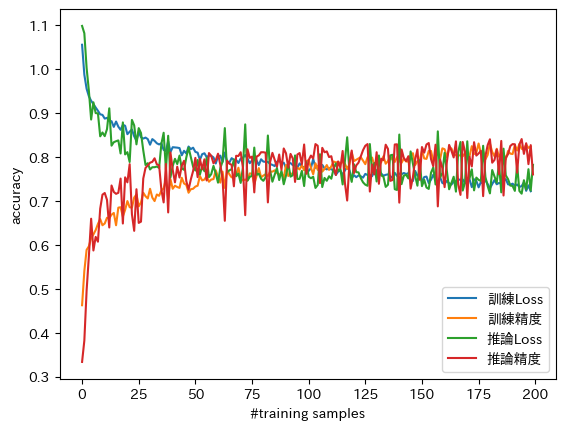

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

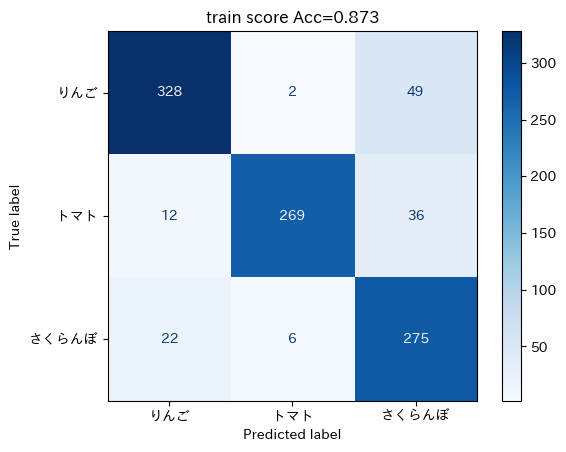

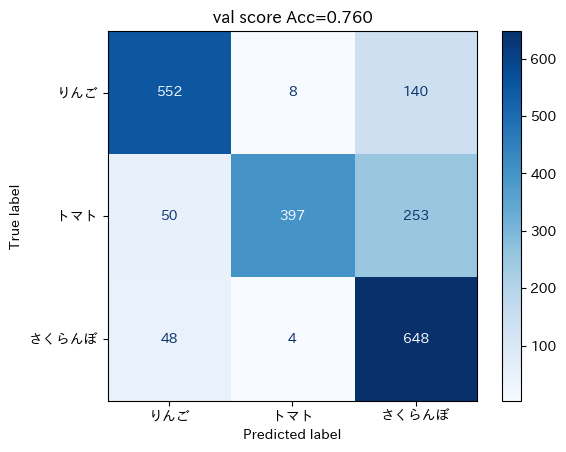

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

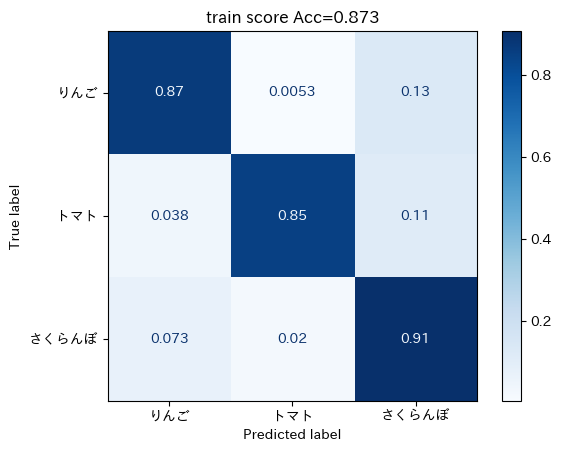

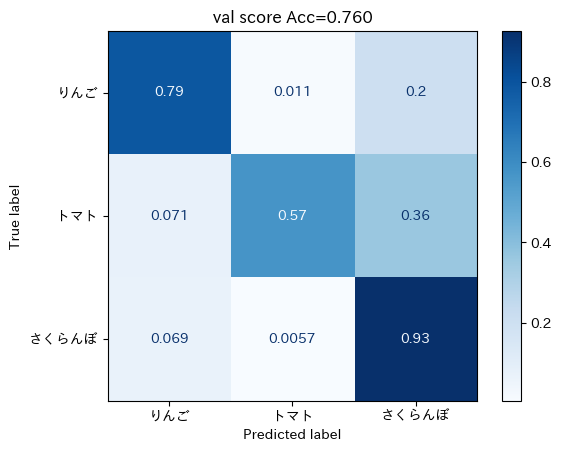

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()